In [4]:
import numpy as np 
import os 
import matplotlib.pyplot as plt
from scipy.fft import fftfreq
from itertools import combinations, product
from scipy.interpolate import CubicSpline
import pickle
from scipy.fftpack import fft2, ifft2, fftshift
import json
from sklearn.linear_model import Ridge

# print(os.getcwd())

Fast generation of CTEM images based on Bloch wave method.

start preparing potential grids
start calculating Bloch wave
start calculating wave function coefficients
start calculating wave function at specific z position
imaging...
done


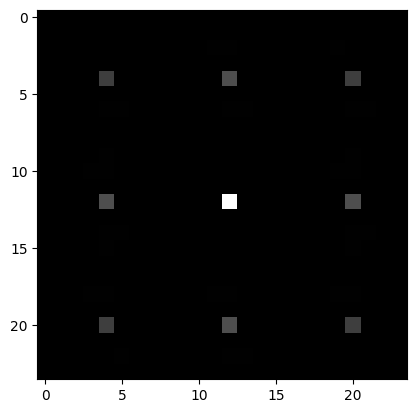

In [ ]:
def supercell_make(frac_coord, supercell_dim):
    nx, ny, nz = supercell_dim
    frac_raw, frac_n = frac_coord.copy(), frac_coord.copy()
    
    for i, j, k in product(range(nx), range(ny), range(nz)):
        if i== 0 and j == 0 and k == 0:
            continue
        
        frac_n = np.concatenate(
            (frac_n, frac_raw + np.array([i,j,k])), axis=0)
        
    return frac_n/np.array([nx,ny,nz])

class bloch_simu:
    def __init__(self,
                lamda, #* inverse wave length, radius of Eward sphere
                prim_cell_vol, #* cell volume for primary cell
                form_fac_func_dict, #* scattering factor expressions for elements (first Born approximation) 
                lattice_sites, #* real-space lattice sites
                lattice_specie, #* elements on corresponding lattice sites
                specie_unic, #* element species in current composition
                 ):
        self.prim_cell_vol = prim_cell_vol
        self.lamda = lamda
        self.form_fac_func_dict = form_fac_func_dict
        
        self.lattice_sites = lattice_sites
        self.lattice_specie = lattice_specie
        self.specie_unic = specie_unic

    def scatter_fac(self, a_vec, b_vec,
                    c_vec, d_vec,
                    g):
        (a1, a2, a3), (b1, b2, b3) = a_vec, b_vec
        (c1, c2, c3), (d1, d2, d3) = c_vec, d_vec
        return a1/(g**2+b1) + a2/(g**2+b2) + a3/(g**2+b3) \
             + c1*np.exp(-d1*g**2) + c2*np.exp(-d2*g**2) + c3*np.exp(-d3*g**2)

    def vh_gen(self, g):
        ''' 
        return g-dependent potential grids
        '''

        s = np.linalg.norm(g, axis=1)
        
        f_mat = np.zeros((len(g), len(self.lattice_sites)))
        f_specie = {}
        for j in self.specie_unic:

            specie_vec = self.form_fac_func_dict[j]
            f_specie[j] = self.scatter_fac(specie_vec['a'], specie_vec['b'],
                                           specie_vec['c'], specie_vec['d'], s)
    
        for specie_i in range(len(self.lattice_sites)):
            f_mat[:,specie_i] = f_specie[self.lattice_specie[specie_i]]
        
        ft_part = f_mat*np.exp(-2*np.pi*1j*np.dot(g, (self.lattice_sites).T))
        return np.sum(ft_part, axis=1)*47.86/self.prim_cell_vol

def g_resmat(g):
    g_resmat = g.reshape(-1,1,3) - g.reshape(1,-1,3)
    return g_resmat

def σe_derive(acc_V, λ):
    e0 = 510998.9461 #* electron rest mass, eV
    return 2*np.pi /(λ*acc_V) * (e0 + acc_V) / (2*e0 + acc_V)

#* some constants
lamda = 1/0.02508  #* inverse electron wavelength, 1/Å, 200 keV
sigma = σe_derive(200e3, 1/lamda)/np.pi/(1/lamda) #* interaction parameter

supercell_dim = np.array([4,4,1]) #TODO supercell dimension
lp = 3.365 #* lattice constant, Å
lattice_vec_prim = np.eye(3)*lp*supercell_dim
lattice_vec = np.eye(3)*lp*supercell_dim #* bulk assumption 
prim_lattice_vol = np.linalg.det(lattice_vec_prim)

#* lattice sites and specie 
prim_cell = np.array([
    [0,0,0],
    [1/2,1/2,0],
    [1/2,0,1/2],
    [0,1/2,1/2,],
])
supercell = supercell_make(prim_cell, supercell_dim) - 1/2

#TODO multi-component cell
c17_ind = np.random.choice(np.arange(len(supercell)), 18, replace=False)
cu_ind = np.setdiff1d(np.arange(len(supercell)), c17_ind)
supercell_n = np.concatenate((supercell[cu_ind], supercell[c17_ind]), axis=0).copy()
lattice_specie = ['Cu']*len(cu_ind) + ['Al']*len(c17_ind)

lattice_sites = supercell_n@lattice_vec

#* k points sampling 
lx, ly, lz = lp*supercell_dim #* scale of supercell 
nkx, nky, nkz = 24,24,6 #TODO k mesh resolution 

kx = fftfreq(nkx, lx/(nkx))
ky = fftfreq(nky, ly/(nky))
kz = fftfreq(nkz, lz/(nkz))

g_buffer = np.array(list(product(kx, ky, kz)))
len_g = len(g_buffer)
g_resmat_buffer = g_resmat(g_buffer)

#* prepare r-space lattice
spacing_grid = lp*supercell_dim/np.array([nkx,nky,nkz])
r0x = np.linspace(-lp*supercell_dim[0]/2, lp*supercell_dim[0]/2-spacing_grid[0], nkx)
r0y = np.linspace(-lp*supercell_dim[1]/2, lp*supercell_dim[1]/2-spacing_grid[1], nky)
nrx, nry = len(r0x), len(r0y)
r0xy = np.array(list(product(r0x, r0y)))
r0 = np.concatenate((r0xy, np.zeros((len(r0xy), 1))), axis=1)

#* load form factor expressions
cu_form = json.load(open('dataset/cu_fac.json', 'r'))
al_form = json.load(open('dataset/al_fac.json', 'r'))
form_fac_func_dict = {'Cu': cu_form, 'Al': al_form}
specie_unic = ['Cu', 'Al']

diff_simu = bloch_simu(lamda, prim_lattice_vol,
                       form_fac_func_dict,
                       lattice_sites, lattice_specie, 
                       specie_unic
                       )

#* prepare U_h matrix (off-diagonal entries)
g_resmat_buffer_ = (g_resmat_buffer.reshape(-1,3))

print(f'start preparing potential grids')
v_gres = diff_simu.vh_gen(g_resmat_buffer_)
u_gres = v_gres.reshape(len_g, len_g)*sigma

#* prepare diagonal entries
k0z = lamda #* z-component for incident beam
g_z = g_buffer[:,-1]
g_norm = np.linalg.norm(g_buffer, axis=1)**2
g_trace_buffer = np.eye(len_g)*(-2*lamda*g_z-g_norm)

bloch_mat = g_trace_buffer + u_gres
#* eigenvalue and eigenvector buffer
print('start calculating Bloch wave')
gamma_j, c_vec = np.linalg.eig(bloch_mat)
gamma_j = gamma_j/2/k0z

#* assume 001 incident beam
print('start calculating wave function coefficients')
k0 = np.array([0,0,lamda])
k0_g = k0 + g_buffer

ft_coef = np.exp(2*np.pi*1j*np.dot(k0_g, r0.T))
psi_r0 = np.ones((1, len(r0)))
psi_g0 = psi_r0@np.linalg.pinv(ft_coef)
alpha_j = np.linalg.inv(c_vec)@psi_g0.T

print('start calculating wave function at specific z position')
z_specify = lp*1 #TODO specify z position
r_z = np.concatenate((r0xy, np.ones((len(r0xy), 1))*z_specify), axis=1)

gamma_z_mat = np.eye(len_g)*np.exp(2*np.pi*1j*gamma_j*z_specify)
psi_gz = c_vec@gamma_z_mat@alpha_j
ft_coef_z = np.exp(2*np.pi*1j*np.dot(k0_g, r_z.T))
psi_r = np.sum(psi_gz.reshape(-1,1)*ft_coef_z, axis=0)

print(f'imaging...')
psi_r_int = np.abs(psi_r).reshape(nrx, nry)
psi_k_int = np.abs(fftshift(fft2(psi_r.reshape(nrx, nry))))
psi_k_int = np.log(0.1*psi_k_int**2+1)

plt.imshow(psi_k_int, cmap='gray')
print('done')